In [2]:
!pip install opencv-python==4.6.0.66 matplotlib==3.6.2 imageio==2.23.0 gdown==4.6.0 tensorflow==2.10.1 --upgrade tensorboard keras

^C
Note: you may need to restart the kernel to use updated packages.


In [1]:
!pip list

Package                      Version
---------------------------- ------------
absl-py                      2.0.0
altair                       5.2.0
anyio                        4.1.0
argon2-cffi                  23.1.0
argon2-cffi-bindings         21.2.0
arrow                        1.3.0
asttokens                    2.4.1
astunparse                   1.6.3
async-lru                    2.0.4
attrs                        23.1.0
Babel                        2.13.1
beautifulsoup4               4.12.2
bleach                       6.1.0
blinker                      1.7.0
cachetools                   5.3.2
certifi                      2023.11.17
cffi                         1.16.0
charset-normalizer           3.3.2
click                        8.1.7
colorama                     0.4.6
comm                         0.2.0
contourpy                    1.2.0
cycler                       0.12.1
debugpy                      1.8.0
decorator                    5.1.1
defusedxml                   0.7.1

In [4]:
import os
import cv2
import tensorflow as tf
import numpy as np
from typing import List
from matplotlib import pyplot as plt
import imageio

In [5]:
physical_devices = tf.config.list_physical_devices('GPU')

try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    pass

# Build Data Loading Functions

In [6]:
import gdown

In [7]:
url = 'https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL'
output = 'data.zip'
gdown.download(url, output, quiet=False)
gdown.extractall('data.zip')

Downloading...
From: https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL
To: c:\lip2\LipNet-main\data.zip
 10%|█         | 43.0M/423M [00:03<00:31, 12.1MB/s]

KeyboardInterrupt: 

In [8]:
def load_video(path: str) -> List[float]:
    
    cap = cv2.VideoCapture(path)
    frames = []
    
    for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))):
        ret, frame = cap.read()
        frame = tf.image.rgb_to_grayscale(frame)
        # Isolating the mouth region using positions
        frames.append(frame[190:236,80:220,:])
    cap.release()
    
    mean = tf.math.reduce_mean(frames)
    std = tf.math.reduce_std(tf.cast(frames, tf.float32))
    
    return tf.cast((frames - mean), tf.float32) / std

In [9]:
vocab = [x for x in "abcdefghijklmnopqrstuvwxyz'?!123456789 "]

 10%|█         | 44.0M/423M [00:20<00:31, 12.1MB/s]

In [10]:
# oov_token: blank value for character it has not seen before
char_to_num = tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="")
num_to_char = tf.keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True
)

print(
    f"The vocabulary is: {char_to_num.get_vocabulary()} "
    f"(size = {char_to_num.vocabulary_size()})"
)

The vocabulary is: ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', '1', '2', '3', '4', '5', '6', '7', '8', '9', ' '] (size = 40)


In [11]:
char_to_num(['b','e','n'])

<tf.Tensor: shape=(3,), dtype=int64, numpy=array([ 2,  5, 14], dtype=int64)>

In [12]:
num_to_char([ 2,  5, 14])

<tf.Tensor: shape=(3,), dtype=string, numpy=array([b'b', b'e', b'n'], dtype=object)>

In [13]:
def load_alignments(path:str) -> List[str]: 
    with open(path, 'r') as f: 
        lines = f.readlines() 
        
    tokens = []
    
    for line in lines:
        line = line.split()
        
        if line[2] != 'sil': 
            tokens = [*tokens,' ',line[2]]
            
    return char_to_num(tf.reshape(tf.strings.unicode_split(tokens, input_encoding='UTF-8'), (-1)))[1:]

In [14]:
def load_data(path: str): 
    path = bytes.decode(path.numpy())
    file_name = path.split('\\')[-1].split('.')[0]
    video_path = os.path.join('data','s1',f'{file_name}.mpg')
    alignment_path = os.path.join('data','alignments','s1',f'{file_name}.align')
    frames = load_video(video_path) 
    alignments = load_alignments(alignment_path)
    
    return frames, alignments

In [15]:
test_path = '.\\data\\s1\\bbal6n.mpg'

In [16]:
tf.convert_to_tensor(test_path).numpy().decode('UTF-8').split('\\')[-1].split('.')[0]

'bbal6n'

In [17]:
# Convert raw string to tensor
frames, alignments = load_data(tf.convert_to_tensor(test_path))

In [18]:
frames

<tf.Tensor: shape=(75, 46, 140, 1), dtype=float32, numpy=
array([[[[ 1.4603739 ],
         [ 1.4603739 ],
         [ 1.4209043 ],
         ...,
         [ 0.15787826],
         [ 0.19734782],
         [ 0.07893913]],

        [[ 1.4603739 ],
         [ 1.4603739 ],
         [ 1.4209043 ],
         ...,
         [ 0.15787826],
         [ 0.07893913],
         [ 0.03946957]],

        [[ 1.4209043 ],
         [ 1.4209043 ],
         [ 1.3814348 ],
         ...,
         [ 0.07893913],
         [ 0.07893913],
         [ 0.07893913]],

        ...,

        [[ 0.94726956],
         [ 0.94726956],
         [ 0.94726956],
         ...,
         [ 9.94633   ],
         [ 9.867392  ],
         [ 9.867392  ]],

        [[ 0.94726956],
         [ 0.94726956],
         [ 0.94726956],
         ...,
         [ 9.90686   ],
         [ 9.867392  ],
         [ 9.867392  ]],

        [[ 0.94726956],
         [ 0.94726956],
         [ 0.94726956],
         ...,
         [ 9.90686   ],
         [ 9.86739

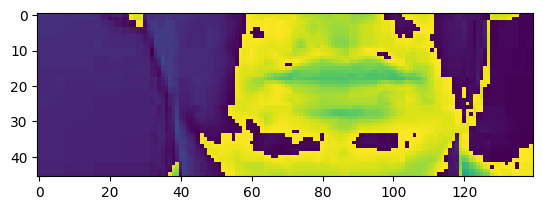

In [19]:
plt.imshow(frames[0])

In [20]:
alignments

<tf.Tensor: shape=(21,), dtype=int64, numpy=
array([ 2,  9, 14, 39,  2, 12, 21,  5, 39,  1, 20, 39, 12, 39, 19,  9, 24,
       39, 14, 15, 23], dtype=int64)>

In [21]:
tf.strings.reduce_join([bytes.decode(x) for x in num_to_char(alignments.numpy()).numpy()])

<tf.Tensor: shape=(), dtype=string, numpy=b'bin blue at l six now'>

In [42]:
def mappable_function(path: str) -> List[str]:
    # Tensorflow that involves raw string processing usually needs to be wrapped inside py_function()
    result = tf.py_function(load_data, [path], (tf.float32, tf.int64))
    
    return result

# Data Pipeline

In [22]:
from matplotlib import pyplot as plt

In [24]:
data = tf.data.Dataset.list_files('./data/s1/*.mpg')
data = data.shuffle(500, reshuffle_each_iteration=False)
data = data.map(mappable_function)
# 75 frames for both the videos and at least 40 tokens for each of the alignments. If not, padded out to 0.
data = data.padded_batch(2, padded_shapes=([75,None,None,None], [40]))
data = data.prefetch(tf.data.AUTOTUNE)

train = data.take(450)
test = data.skip(450)

NameError: name 'mappable_function' is not defined

In [83]:
len(test)

50

In [47]:
frames, alignments = data.as_numpy_iterator().next()

In [48]:
len(frames)

2

In [49]:
test = data.as_numpy_iterator()

In [50]:
val = test.next(); val[0]

array([[[[[1.4253203 ],
          [1.4253203 ],
          [1.4253203 ],
          ...,
          [0.03654667],
          [0.2558267 ],
          [0.21928003]],

         [[1.4253203 ],
          [1.4253203 ],
          [1.4253203 ],
          ...,
          [0.07309335],
          [0.2558267 ],
          [0.21928003]],

         [[1.3522269 ],
          [1.3522269 ],
          [1.3522269 ],
          ...,
          [0.21928003],
          [0.2923734 ],
          [0.2923734 ]],

         ...,

         [[0.98676014],
          [0.98676014],
          [0.9502135 ],
          ...,
          [0.        ],
          [0.        ],
          [0.        ]],

         [[0.98676014],
          [0.98676014],
          [0.9502135 ],
          ...,
          [0.        ],
          [9.319402  ],
          [9.319402  ]],

         [[0.98676014],
          [0.98676014],
          [0.9502135 ],
          ...,
          [0.        ],
          [9.319402  ],
          [9.319402  ]]],


        [[[1.3887

In [52]:
imageio.mimsave('./animation.gif', val[0][1], fps=10)

Lossy conversion from float32 to uint8. Range [0.0, 9.913178443908691]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 9.913178443908691]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 9.913178443908691]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 9.913178443908691]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 9.913178443908691]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 9.913178443908691]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 9.913178443908691]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. R

Lossy conversion from float32 to uint8. Range [0.0, 9.913178443908691]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 9.913178443908691]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 9.913178443908691]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 9.913178443908691]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 9.913178443908691]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 9.913178443908691]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 9.913178443908691]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. R

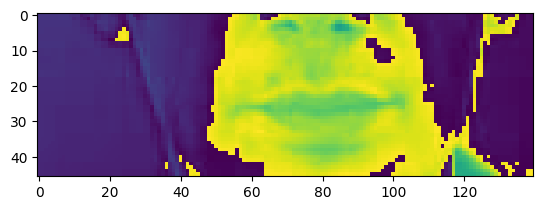

In [56]:
# First index: videos
# Second index: first video out of the batch
# Third index: return the first frame in the video
plt.imshow(val[0][0][0])

In [57]:
tf.strings.reduce_join([num_to_char(word) for word in val[1][0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'bin white by a seven again'>

# Neural Network

In [59]:
import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, LSTM, Dense, Dropout, Bidirectional, MaxPool3D, Activation, Reshape, BatchNormalization, TimeDistributed, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

In [60]:
data.as_numpy_iterator().next()[0][0].shape

(75, 46, 140, 1)

In [61]:
model = Sequential()
# 128 kernels, 3x3 in size
# padding preserves shape of our inputs
model.add(Conv3D(128,3,input_shape=(75,46,140,1),padding='same'))
model.add(Activation('relu'))
# Take max values from inside each frame and condense it down to a 2x2 frame
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(256,3,padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(75,3,padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

# 75 inputs into our LSTM network which will output 75 units that represent the text-based characters
model.add(TimeDistributed(Flatten()))

# Bidirectional: l -> r and r -> l
model.add(Bidirectional(LSTM(128,kernel_initializer='Orthogonal', return_sequences=True)))
# Regularization and drop 50% of the units
model.add(Dropout(.5))

model.add(Bidirectional(LSTM(128,kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Dense(char_to_num.vocabulary_size()+1, kernel_initializer='he_normal', activation='softmax'))

In [62]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 75, 46, 140, 128)  3584      
                                                                 
 activation (Activation)     (None, 75, 46, 140, 128)  0         
                                                                 
 max_pooling3d (MaxPooling3D  (None, 75, 23, 70, 128)  0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 75, 23, 70, 256)   884992    
                                                                 
 activation_1 (Activation)   (None, 75, 23, 70, 256)   0         
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 75, 11, 35, 256)  0         
 3D)                                                    

In [63]:
yhat = model.predict(val[0])

1/1 [==============================] - 4s 4s/step


In [68]:
tf.strings.reduce_join([num_to_char(tf.argmax(x)) for x in yhat[0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'zzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzz5zzzzzzzzzzzzzzzzzzzzzzzzzzzzzz5555zkkkkkk'>

In [69]:
[num_to_char(x) for x in tf.argmax(yhat[0],axis=1)]

[<tf.Tensor: shape=(), dtype=string, numpy=b'z'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'z'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'z'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'z'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'z'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'z'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'z'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'z'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'z'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'z'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'z'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'z'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'z'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'z'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'z'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'z'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'z'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'z'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'z'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'z'>,


In [67]:
# 75 outputs with each having an array of 41 values
yhat[0].shape
tf.argmax(yhat[0],axis=1)

<tf.Tensor: shape=(75,), dtype=int64, numpy=
array([26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26,
       26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 34,
       26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26,
       26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 34, 34, 34, 34,
       26, 11, 11, 11, 11, 11, 11], dtype=int64)>

In [70]:
model.input_shape

(None, 75, 46, 140, 1)

In [71]:
model.output_shape

(None, 75, 41)

# Training

In [72]:
# Drop our learning rate each epoch
def scheduler(epoch, lr):
    if epoch < 30:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

In [73]:
def CTCLoss(y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype='int64')
    input_length = tf.cast(tf.shape(y_pred)[1], dtype='int64')
    label_length = tf.cast(tf.shape(y_true)[1], dtype='int64')
    
    input_length = input_length * tf.ones(shape=(batch_len,1), dtype='int64')
    label_length = label_length * tf.ones(shape=(batch_len,1), dtype='int64')
    
    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    
    return loss

In [74]:
class ProduceExample(tf.keras.callbacks.Callback):
    def __init__(self, dataset) -> None:
        self.dataset = dataset.as_numpy_iterator()
    
    def on_epoch_end(self, epoch, logs=None) -> None:
        data = self.dataset.next()
        yhat = self.model.predict(data[0])
        # Decode outputs from the CTC classifier
        decoded = tf.keras.backend.ctc_decode(yhat, [75,75], greedy=False)[0][0].numpy()
        
        for x in range(len(yhat)):
            print('Original: ', tf.strings.reduce_join(num_to_char(data[1][x])).numpy().decode('UTF-8'))
            print('Prediction: ', tf.strings.reduce_join(decoded(data[x])).numpy().decode('UTF-8'))
            print('~'*100)

In [75]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss=CTCLoss)

In [76]:
checkpoint_callback = ModelCheckpoint(os.path.join('models', 'checkpoint'), monitor='loss', save_weights_only=True)

In [77]:
schedule_callback = LearningRateScheduler(scheduler)

In [78]:
# Make some predictions after each epoch
example_callback = ProduceExample(data)

In [84]:
model.fit(train, validation_data=test, epochs=100, callbacks=[checkpoint_callback, schedule_callback, example_callback])

Epoch 1/100
  2/450 [..............................] - ETA: 3:40:02 - loss: 128.7669

KeyboardInterrupt: 

# Prediction

In [85]:
url = 'https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y'
output = 'checkpoints.zip'
gdown.download(url, output, quiet=False)
gdown.extractall('checkpoints.zip', 'models')

Downloading...
From: https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y
To: C:\Users\yacoo\LipReadingDeepLearning\LipReading\checkpoints.zip
100%|█████████████████████████████████████████████████████████████████████████████| 94.5M/94.5M [00:13<00:00, 6.86MB/s]


['models\\checkpoint.index',
 'models\\__MACOSX/._checkpoint.index',
 'models\\checkpoint.data-00000-of-00001',
 'models\\__MACOSX/._checkpoint.data-00000-of-00001',
 'models\\checkpoint',
 'models\\__MACOSX/._checkpoint']

In [86]:
model.load_weights('models/checkpoint')

In [87]:
test_data = test.as_numpy_iterator()

In [99]:
sample = test_data.next()

In [100]:
yhat = model.predict(sample[0])

1/1 [==============================] - 2s 2s/step


In [101]:
print('~'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in sample[1]]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ REAL TEXT


[<tf.Tensor: shape=(), dtype=string, numpy=b'bin red by g five again'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'bin green at a six now'>]

In [102]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75,75], greedy=True)[0][0].numpy()

In [103]:
print('~'*100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ PREDICTIONS


[<tf.Tensor: shape=(), dtype=string, numpy=b'bin red by g five again'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'bin green at a six now'>]

# Test on a Video

In [123]:
sample = load_data(tf.convert_to_tensor('.\\data\\s1\\sbia2p.mpg'))

In [124]:
yhat = model.predict(tf.expand_dims(sample[0],axis=0))

1/1 [==============================] - 1s 1s/step


In [125]:
yhat.shape

(1, 75, 41)

In [126]:
print('~'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in [sample[1]]]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ REAL TEXT


[<tf.Tensor: shape=(), dtype=string, numpy=b'set blue in a two please'>]

In [127]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75], greedy=True)[0][0].numpy()

In [128]:
print('~'*100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ PREDICTIONS


[<tf.Tensor: shape=(), dtype=string, numpy=b'set blue in a two please'>]